In [8]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

RANDOM_STATE = 42
BATCH_SIZE = 8
NUM_WORKERS = 4
IMG_SIZE = (224, 224)

cudnn.benchmark = True
plt.ion()   # interactive mode

In [9]:
class AddGaussianNoise(object):
    def __init__(self, mean, std):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.normal(self.mean, self.std, size=tensor.shape)
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [10]:
# Data augmentation

# ImageNet Normalization
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

std_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

augmentation = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    AddGaussianNoise(0, 0.1)
])

In [26]:
# Load the datasets

train_dir = "./img_data/train"
test_dir = "./img_data/test"
gen_dir = "./generated"

train_data = datasets.ImageFolder(root=train_dir, transform=std_transform)
train_data_aug_1 = datasets.ImageFolder(root=train_dir, transform=augmentation)
train_data_aug_2 = datasets.ImageFolder(root=train_dir, transform=augmentation)
train_data_aug_3 = datasets.ImageFolder(root=train_dir, transform=augmentation)
# train_data_gen = datasets.ImageFolder(root=gen_dir, transform=std_transform)

# Combine real and augmented train data
train_data = torch.utils.data.ConcatDataset([train_data, train_data_aug_1, train_data_aug_2, train_data_aug_3])

test_data = datasets.ImageFolder(root=test_dir, transform=std_transform)

# Dataloaders
train_dataloader = torch.utils.data.DataLoader(dataset=train_data, 
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = torch.utils.data.DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE, 
                             num_workers=NUM_WORKERS, 
                             shuffle=False)

dataloaders={'train': train_dataloader, 'test': test_dataloader}
dataset_sizes = {'train': len(train_data), 'test': len(test_data)}

class_names = test_data.classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

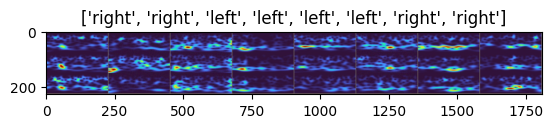

In [12]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [13]:
train_acc = []
test_acc = []

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_acc.append(epoch_acc)
            else:
                test_acc.append(epoch_acc)
            
            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [14]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [15]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=2,
                    bias=True)
)

model = model.to(device)

In [16]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

# Decay LR by a factor of 0.1 every 2 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.05)

In [10]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------
train Loss: 0.8080 Acc: 0.6298
test Loss: 0.5567 Acc: 0.7174

Epoch 1/14
----------
train Loss: 0.5634 Acc: 0.7032
test Loss: 0.5310 Acc: 0.7242

Epoch 2/14
----------
train Loss: 0.5164 Acc: 0.7417
test Loss: 0.5553 Acc: 0.7106

Epoch 3/14
----------
train Loss: 0.4073 Acc: 0.8075
test Loss: 0.5134 Acc: 0.7609

Epoch 4/14
----------
train Loss: 0.3680 Acc: 0.8286
test Loss: 0.5266 Acc: 0.7418

Epoch 5/14
----------
train Loss: 0.3313 Acc: 0.8523
test Loss: 0.5557 Acc: 0.7405

Epoch 6/14
----------
train Loss: 0.3027 Acc: 0.8671
test Loss: 0.5633 Acc: 0.7391

Epoch 7/14
----------
train Loss: 0.3005 Acc: 0.8691
test Loss: 0.5665 Acc: 0.7446

Epoch 8/14
----------
train Loss: 0.2929 Acc: 0.8742
test Loss: 0.5733 Acc: 0.7418

Epoch 9/14
----------
train Loss: 0.2897 Acc: 0.8757
test Loss: 0.5812 Acc: 0.7432

Epoch 10/14
----------
train Loss: 0.2903 Acc: 0.8722
test Loss: 0.5829 Acc: 0.7486

Epoch 11/14
----------
train Loss: 0.2900 Acc: 0.8730
test Loss: 0.5852 Acc

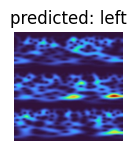

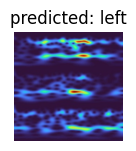

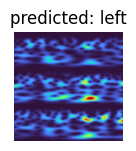

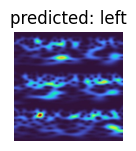

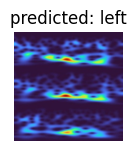

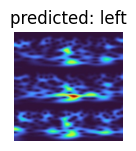

In [11]:
visualize_model(model)

In [17]:
torch.save(model.state_dict(), "classifier2.pth")

In [13]:
train_acc = [acc.item() if type(acc) != float else acc for acc in train_acc]
test_acc = [acc.item() if type(acc) != float else acc for acc in test_acc]

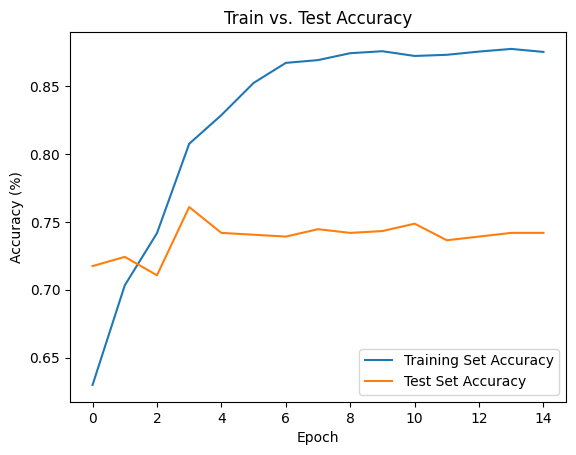

In [14]:
plt.plot(train_acc, label="Training Set Accuracy")
plt.plot(test_acc, label="Test Set Accuracy")
plt.title("Train vs. Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")

plt.legend()

[Text(0.5, 47.7222222222222, 'Actual Label'),
 Text(120.72222222222221, 0.5, 'Predicted Label'),
 Text(0.5, 1.0, 'Confusion Matrix')]

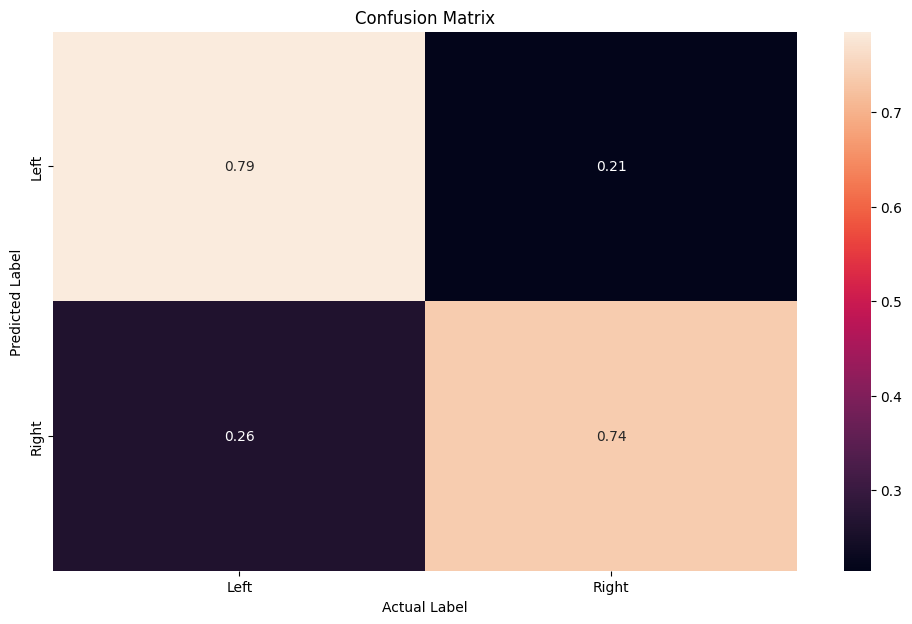

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

with torch.no_grad():
    # iterate over test data
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('Left', 'Right')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])

plt.figure(figsize = (12,7))
ax = sn.heatmap(df_cm, annot=True)
ax.set(xlabel='Actual Label', ylabel='Predicted Label', title="Confusion Matrix")

In [16]:
acc = (df_cm['Left']['Left'] + df_cm['Right']['Right']) / 2
kappa = (acc-0.5)/0.5

kappa

0.5217391304347827